# Project: Predicting Outcome of Banking Marketing Campaign

The goal is to predict if a client will subscribe to a term deposit of a Portuguese banking institution based on its marketing campaign, as well as client characteristics. The marketing campaigns were based on phone calls. Often, the same client will be contacted more than once to assess if the product offered will be subscribed.

# 1. Data Source:

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).



Sources:
- Data Description: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
- Data Source: https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# set pandas to display all columns
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('banking.csv', header=0)

In [3]:
print('Shape of dataset:', data.shape)

mis_val = data.isnull().sum().sum()
print('Number of missing values:', mis_val)

data.sample(5)

Shape of dataset: (41188, 21)
Number of missing values: 0


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
29465,36,admin.,divorced,university.degree,unknown,yes,yes,cellular,jul,wed,123,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
3826,33,admin.,married,university.degree,no,no,no,cellular,aug,fri,157,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
40972,58,retired,married,basic.4y,no,no,no,cellular,apr,wed,1307,1,999,0,nonexistent,-1.8,93.749,-34.6,0.639,5008.7,1
16055,57,blue-collar,married,basic.9y,no,yes,no,cellular,jul,tue,106,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6430,54,housemaid,divorced,basic.4y,no,yes,yes,cellular,jul,mon,78,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0


<div class="alert alert-block alert-info">
<b>Note:</b> The dataset consists on 41,188 rows with 20 features and 1 target variable. There are no missing values. This is also a binary classification problem as there are only two outcomes (0: Do not Subscribe, 1: Subscribe)
</div>

---

# 2 Data attribute info:


### __Input variables__

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, __this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.__

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

---

# 3. Exploratory Data Analysis

Analysis of distribution of Class Labels
   count          %
0  36548  88.734583
1   4640  11.265417


<AxesSubplot:ylabel='Frequency'>

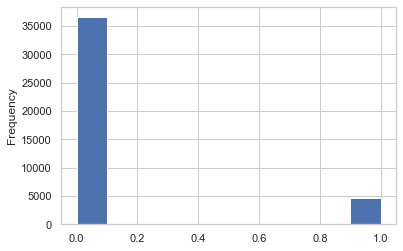

In [4]:
data_label = data['y'].value_counts().to_frame()
data_label.columns = ['count']
data_label['%'] = (data_label['count'] / data_label['count'].sum()) * 100

print('Analysis of distribution of Class Labels')
print(data_label)

data['y'].plot.hist()

### Observation:
    
We have an imbalance dataset. There are far more non-subscriptions (89%) than subscriptions (11%).


---

In [5]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


### Observations

- age: The average age of customers who subscribe is higher than those who don't. Without doing any statistical testing however we do not know if they are significantly different.


- duration: Higher call duration for customer who subscribe. However, as stated in the feature description, the duration is not know before a call is performed and the outcome of `y` is known after call. Hence it should be discarded in the predictive model.


- campaign: The number of contacts for subscribed customers are lower compared to non-subcriptions, indicating an effort to convert the un-subscribed customers.


- pdays: pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.


- other economic variables (e.g. employment, CPI, euribor): At a glance it is difficult to ascertain the the impact of these economic indicators.
    - However, it seems that people are more likely to subscribe to the term deposit during times of negative employment variation rates (assumed to be change in employment rates), and, 
    - surprisingly, when the short term euribor is low (this could be due to a corresponding period of steeper yield curves so long term deposit rates can be more attractive).

------

## 3. 1 Check Unique Values of the features

In [6]:
for i in data.columns:
    print(i)
    print(data[i].unique())
    print('')
    print('-'*60)

age
[44 53 28 39 55 30 37 36 27 34 41 33 26 52 35 40 32 49 38 47 46 29 54 42
 72 48 43 56 31 24 68 59 50 45 25 57 63 58 60 64 51 23 20 74 80 61 62 75
 21 82 77 70 76 73 66 22 71 19 79 88 65 67 81 18 84 69 98 85 83 78 92 86
 94 17 91 89 87 95]

------------------------------------------------------------
job
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

------------------------------------------------------------
marital
['married' 'single' 'divorced' 'unknown']

------------------------------------------------------------
education
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']

------------------------------------------------------------
default
['unknown' 'no' 'yes']

------------------------------------------------------------
housing
['yes' 'no' 'unknown']

-------------------------------------------------------

------

## 3. 2 Visualization of Features (Separated into Subscribed and Non-Subscribed)

In [7]:
# Number of each type of column
df_dtype = data.dtypes.value_counts().to_frame()
df_dtype.columns = ['count']
df_dtype['%'] = (df_dtype['count'] / df_dtype['count'].sum()) * 100
print(df_dtype)

         count          %
object      10  47.619048
int64        6  28.571429
float64      5  23.809524


In [8]:
# get name of columns with numerical data and categorical data

coltype_num = list(data.select_dtypes(include=['int64', 'float64']).columns)
coltype_cat = list(data.select_dtypes(include=['object']).columns)

C:\Users\aooi5\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\aooi5\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


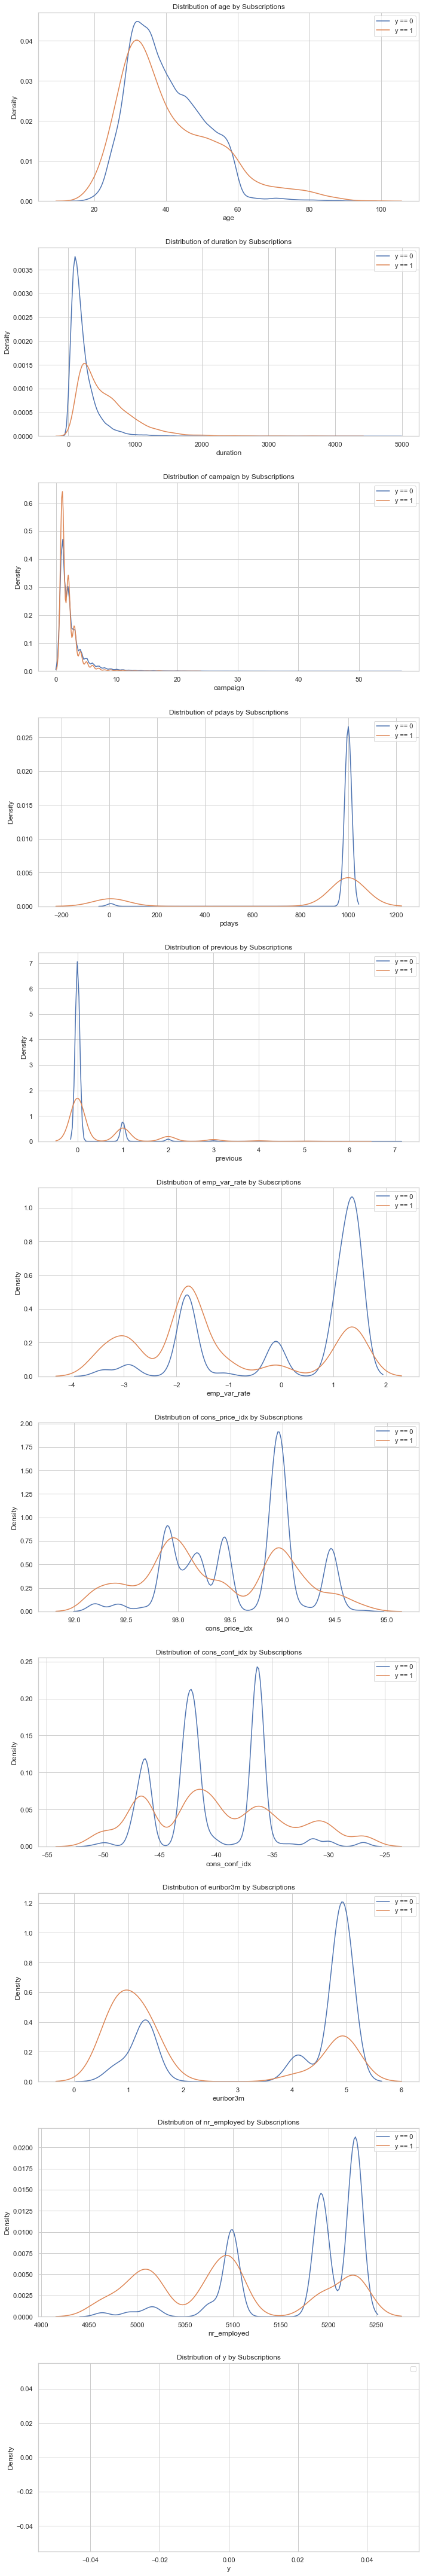

In [9]:
# we first plot some KDE plots to compared the distributions of numerical features
# across subscriptions and non-subscriptions

plt.figure(figsize = (10, 60))

# iterate through the sources
for i, source in enumerate(coltype_num):
        
    # create a new subplot for each source
    plt.subplot(len(coltype_num), 1, i + 1)
    # plot non_subscriptions
    sns.kdeplot(data.loc[data['y'] == 0, source], label = 'y == 0')
    # plot subscriptions
    sns.kdeplot(data.loc[data['y'] == 1, source], label = 'y == 1')
    
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Subscriptions' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

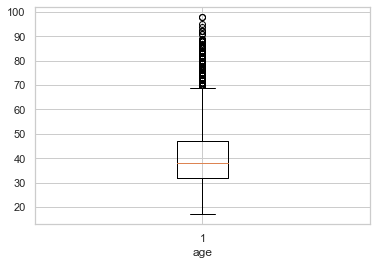

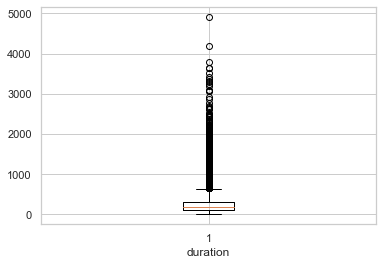

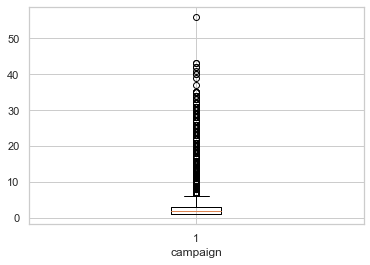

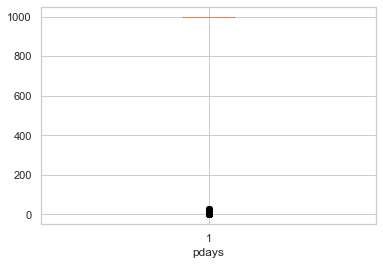

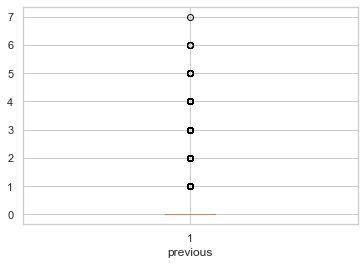

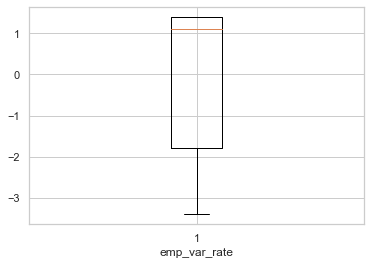

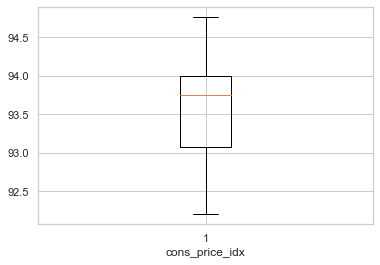

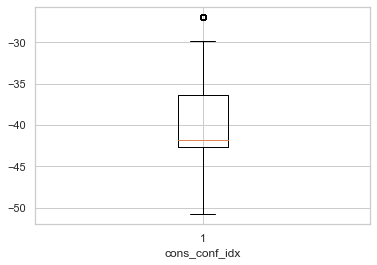

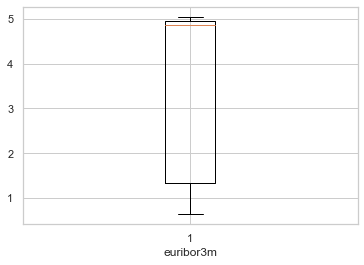

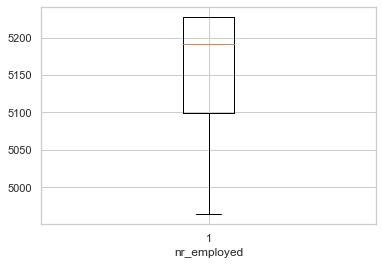

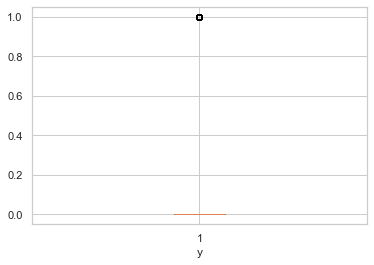

In [10]:
for col in coltype_num:
    plt.boxplot(data[col])
    plt.xlabel(col)
    plt.show()

### Observations:

It is not apparent visually which of the numerical features are important predictos of the outcome variable, and may have the similar shape of KDE distributions. It appears however that economic indicators like `emp_var_rate`, `euribor3m` (which are also highly correlated) are good predictors. 

## 3.3 Visualization of Categorical Data

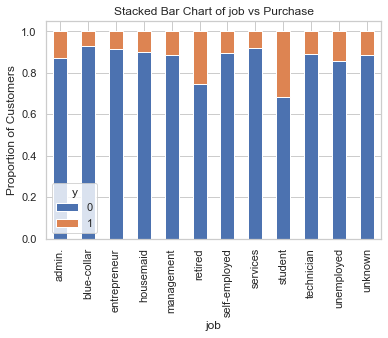

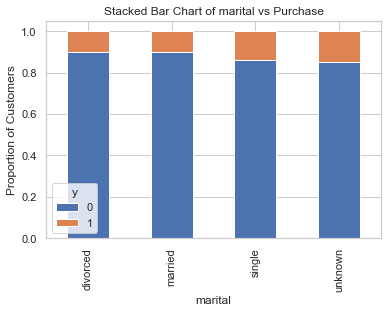

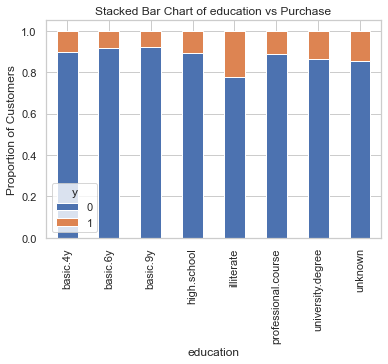

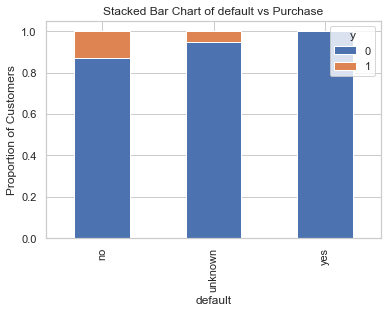

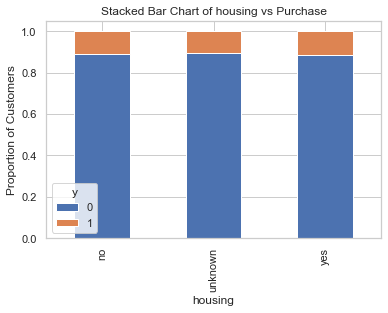

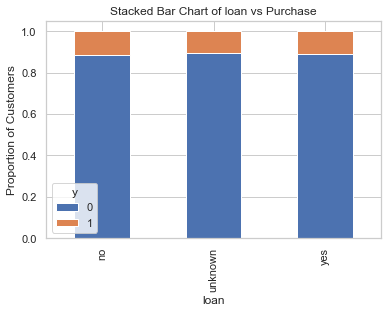

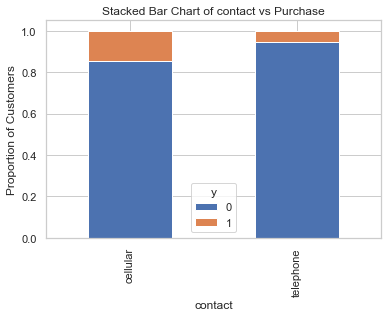

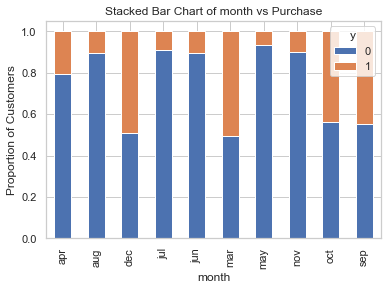

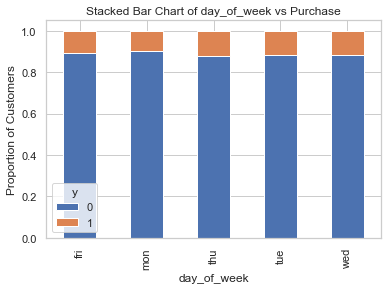

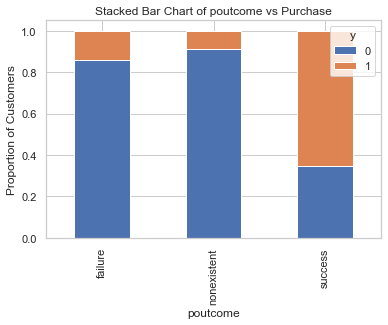

In [11]:
# we also plot a stacked bar chart to see if there are obvious distinctions on categorical features

for col in coltype_cat:
    table = pd.crosstab(data[col], data.y)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title(f'Stacked Bar Chart of {col} vs Purchase')
    plt.xlabel(col)
    plt.ylabel('Proportion of Customers')

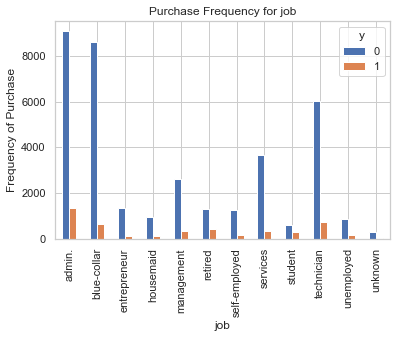

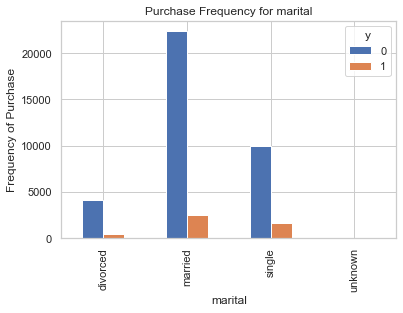

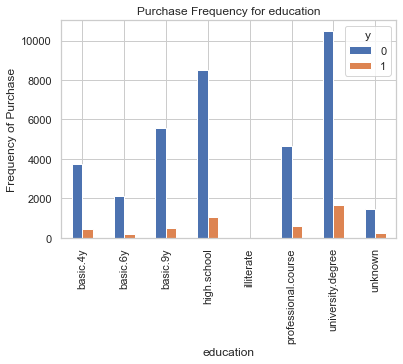

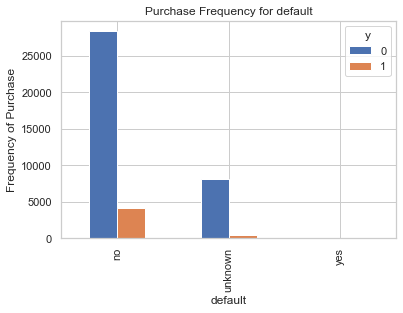

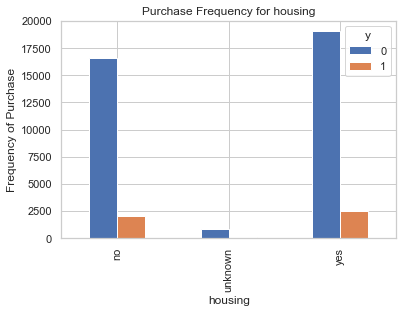

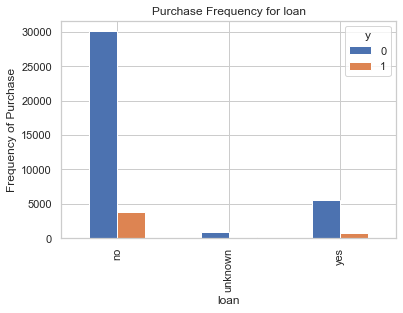

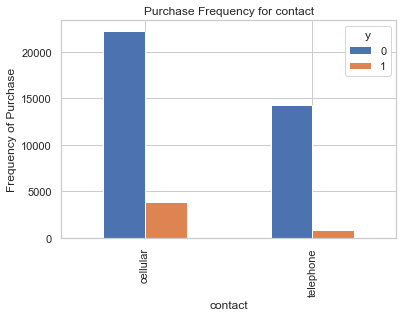

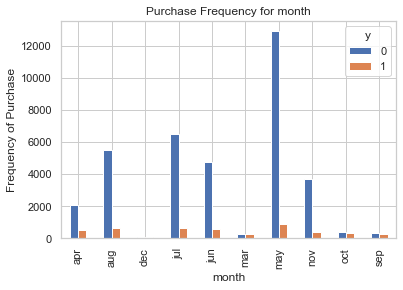

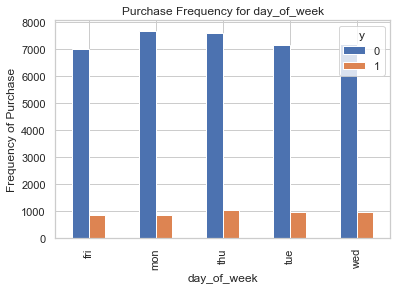

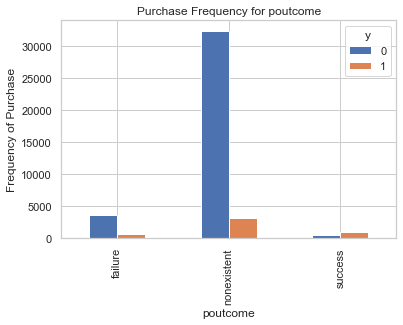

In [12]:
for col in coltype_cat:
    pd.crosstab(data[col], data['y']).plot(kind='bar')
    plt.title(f'Purchase Frequency for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency of Purchase')

## 3.4 Normalized relative frequency of Categorical Features

We also list the normalized relative frequencey of the target class by each categorical features, and plot the difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and vice versa.

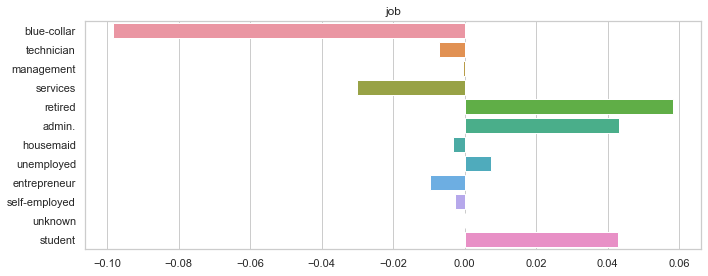

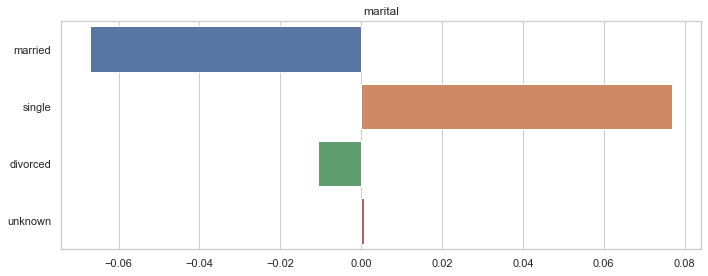

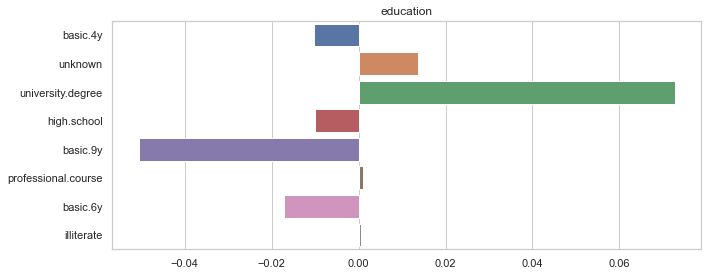

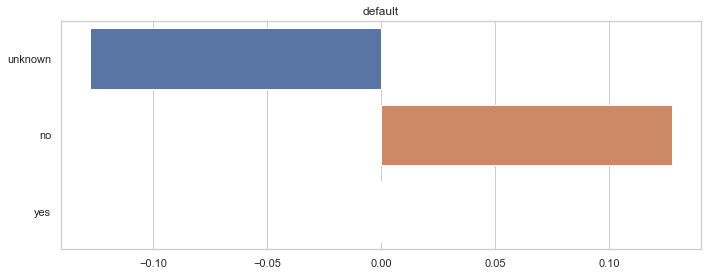

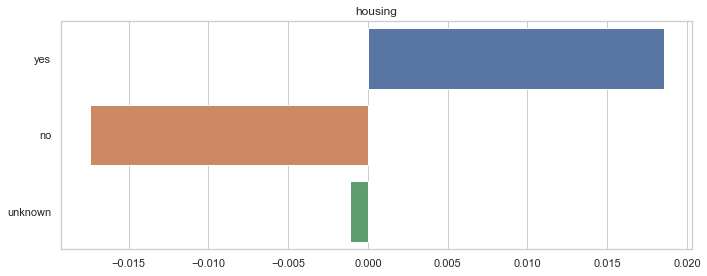

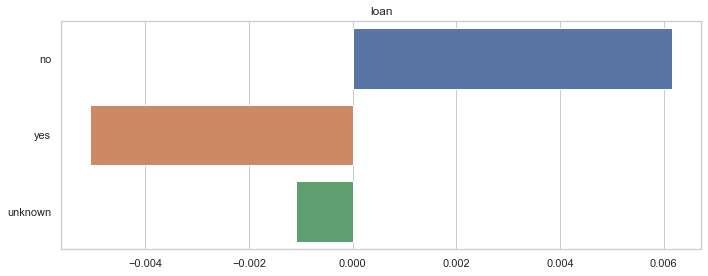

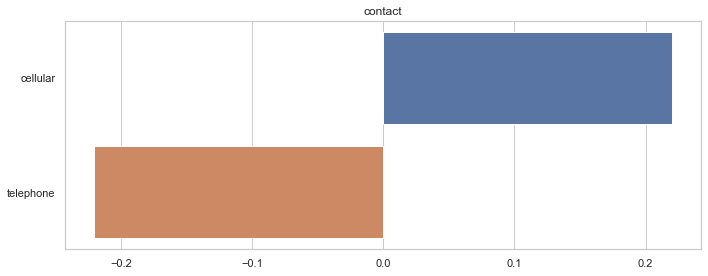

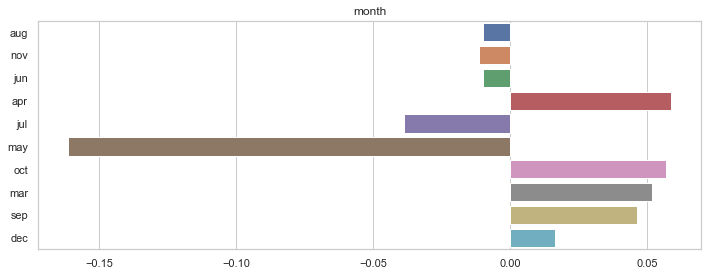

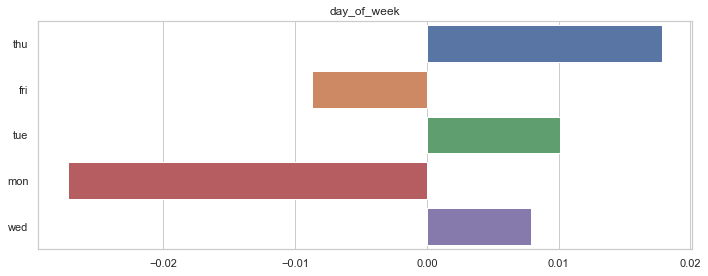

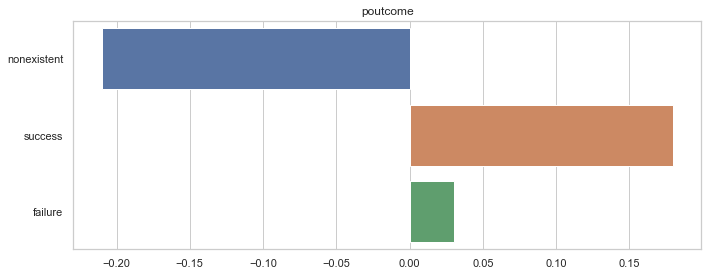

In [13]:
freq_pos = (data['y'].values == 1).sum()
freq_neg = (data['y'].values == 0).sum()

for col in coltype_cat:
    plt.figure(figsize=(10,4))
    
    # get the number of positive and negative counts
    # for each category in the feature
    pos_counts = data.loc[data.y.values == 1, col].value_counts()
    neg_counts = data.loc[data.y.values == 0, col].value_counts()

    # find all the category labels in the feature
    all_counts = list(data[col].unique())

    # calculate the relative proportion of positive and negative counts
    # and find the difference
    # where a postive value denote a more ppl in that category subscribed, and vice versa
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()

    all_index = all_counts[:]

    all_counts = [(pos_counts.get(k,0) / freq_pos) - (neg_counts.get(k,0) / freq_neg) for k in all_counts]

    sns.barplot(x=all_counts, y=all_index)
    plt.title(col)
    plt.tight_layout()

### Observations:

Some stand-out categorical features like `job`, `education`, `default`, `month`, and `poutcome` seem good predictors of the outcome variable.
In addition, we can also see, in each features, which categories are more likely to subscribe

------

# 4. Dealing with Missing Values by Imputation

## 4.1 Categorical Features

In [14]:
unknown_cnt = []

for col in coltype_cat:
    unknown_cnt.append(data[data[col] == 'unknown'].value_counts().sum())

df_missing_cat = pd.DataFrame(coltype_cat)
unknown_cnt = pd.DataFrame(unknown_cnt)
df_missing_cat = pd.concat([df_missing_cat, unknown_cnt], axis=1)
df_missing_cat.columns = ['Features', 'No. of unknowns']
df_missing_cat['% of unknowns'] = df_missing_cat['No. of unknowns'] / data.shape[0] *100

In [15]:
df_missing_cat.sort_values(by=['% of unknowns'], ascending=False)

,Features,No. of unknowns,% of unknowns
3,default,8597,20.872584
2,education,1731,4.202680
4,housing,990,2.403613
5,loan,990,2.403613
0,job,330,0.801204
1,marital,80,0.194231
6,contact,0,0.000000
7,month,0,0.000000
8,day_of_week,0,0.000000
9,poutcome,0,0.000000


### Imputing `education` from `job`
- First we simplify the categories in `education` by combining basic education together
- Next we run a cross-tabulation to see if we can find any relationships in the dataset

In [16]:
# simplifying the education feature

education_dict = {'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic'}
data = data.replace({'education': education_dict})

In [17]:
pd.crosstab(data['job'], data['education'])

education,basic,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,
admin.,727,3329,1,363,5753,249
blue-collar,7367,878,8,453,94,454
entrepreneur,418,234,2,135,610,57
housemaid,645,174,1,59,139,42
management,351,298,0,89,2063,123
retired,817,276,3,241,285,98
self-employed,338,118,3,168,765,29
services,746,2682,0,218,173,150
student,138,357,0,43,170,167


Here we see that:


- (job -> education):
    - blue-collars: mainly have basic education, and hence we impute unknown blue-collar educaion to be 'basic'
    - management: mainy have university.degrees, and we use that as basis for imputation
    - services: mainly high.school


- (education -> job):
    - basic: blue-collar
    - professional.course: technician

In [18]:
# performing imputation based on the rules above

data.loc[(data['education']=='unknown') & (data['job']=='management'), 'education'] = 'university.degree'
data.loc[(data['education']=='unknown') & (data['job']=='services'), 'education'] = 'high.school'
data.loc[(data['education']=='unknown') & (data['job']=='housemaid'), 'education'] = 'basic'
data.loc[(data['job'] == 'unknown') & (data['education']=='basic'), 'job'] = 'blue-collar'
data.loc[(data['job']=='unknown') & (data['education']=='professional.course'), 'job'] = 'technician'

In [19]:
unknown_cnt = []

for col in coltype_cat:
    unknown_cnt.append(data[data[col] == 'unknown'].value_counts().sum())

df_missing_cat = pd.DataFrame(coltype_cat)
unknown_cnt = pd.DataFrame(unknown_cnt)
df_missing_cat = pd.concat([df_missing_cat, unknown_cnt], axis=1)
df_missing_cat.columns = ['Features', 'No. of unknowns']
df_missing_cat['% of unknowns'] = df_missing_cat['No. of unknowns'] / data.shape[0] *100

df_missing_cat.sort_values(by=['% of unknowns'], ascending=False)

,Features,No. of unknowns,% of unknowns
3,default,8597,20.872584
2,education,1416,3.437895
4,housing,990,2.403613
5,loan,990,2.403613
0,job,213,0.517141
1,marital,80,0.194231
6,contact,0,0.000000
7,month,0,0.000000
8,day_of_week,0,0.000000
9,poutcome,0,0.000000


## 4.2 Dealing with Missing Values - Numerical Data

We note from the box plot that `pdays` has a large outlier: 999 (which means that the client was not previously contacted). This value takes up 96% of this feature (meaning 96% of the clients were not contacted before).


To deal with this, we can attempt to convert this feature into categorical data

In [20]:
data.pdays.value_counts()/data.shape[0]

999    0.963217
3      0.010658
6      0.010003
4      0.002865
9      0.001554
2      0.001481
7      0.001457
12     0.001408
10     0.001263
5      0.001117
13     0.000874
11     0.000680
1      0.000631
15     0.000583
14     0.000486
8      0.000437
0      0.000364
16     0.000267
17     0.000194
18     0.000170
19     0.000073
22     0.000073
21     0.000049
20     0.000024
25     0.000024
26     0.000024
27     0.000024
Name: pdays, dtype: float64

In [21]:
pdays_cat = pd.cut(data.pdays, bins=[0, 4, 14, 998, 999], labels=['pdays_less_5', 'pdays_bet_5_15', 'pdays_greater_15', 'p_days_missing'])
data.insert(12, 'pdays_cat', pdays_cat)

In [22]:
# create a new dataframe to work with

df = data.copy()

# remove pdays as we have converted them to categorical data
df.drop('pdays', inplace=True, axis=1)

In [23]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays_cat',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

# 5. Data Pre-processing

## 5.1 Encoding Categorical Variables

For our case, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories

In [24]:
# label encode features with only 2 categories
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# track the columns that is transformed
le_track = []

# iterate through the column names in the dataset
for col in df:
    # if the columns are categorical:
    if df[col].dtype == 'object':
        
        # if the number of categories are 2, we use Label Encoding:
        if df[col].nunique() <= 2:
            # fit the column
            le.fit(df[col])
            # transform the data set
            df[col] = le.transform(df[col])
        
            le_track.append(col)
            

# one-hot encode remaining categories
df = pd.get_dummies(df)

In [25]:
df


,age,contact,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_cat_pdays_less_5,pdays_cat_pdays_bet_5_15,pdays_cat_pdays_greater_15,pdays_cat_p_days_missing,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,0,210,1,0,1.4,93.444,-36.1,4.963,5228.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
1,53,0,138,1,0,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,28,0,339,3,2,-1.7,94.055,-39.8,0.729,4991.6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,39,0,185,2,0,-1.8,93.075,-47.1,1.405,5099.1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,55,0,137,1,1,-2.9,92.201,-31.4,0.869,5076.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,1,222,1,0,1.4,94.465,-41.8,4.866,5228.1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
41184,31,1,196,2,0,1.1,93.994,-36.4,4.860,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
41185,42,1,62,3,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
41186,48,1,200,2,0,-3.4,92.431,-26.9,0.742,5017.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [26]:
df.columns

Index(['age', 'contact', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of

# 6. Data Modeling

We use Logistic Regression to model the data. First, we will feed in all available features to the model to see how they behave.

## 6.1 Using a Probit Link Function

In [27]:
from statsmodels.discrete.discrete_model import Probit
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'y']
y = df.loc[:, df.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)



In [28]:
model = Probit(y_train, X_train)
probit_model = model.fit()
print(probit_model.summary())

         Current function value: 0.209530
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                         Probit   Df Residuals:                    28777
Method:                           MLE   Df Model:                           53
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.4067
Time:                        18:47:49   Log-Likelihood:                -6041.0
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0005      0.002      0.315      0.753      -0.003       0.003
contact 

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


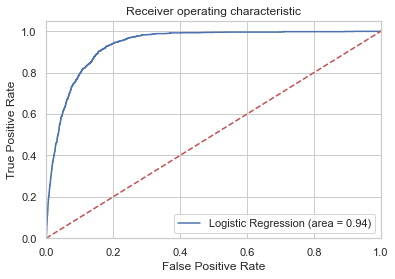

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, probit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, probit_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations from the Probit Model

- It apears that the ML estimation failed to converge and hence we cannot rely on the results. It is likely the non-convergence is due to the high number of independent variables used in the model.
- From the results, the p-value of many features seem to be very high. One of our interpretation is that we should remove this features from our regression

---

## 6.2 Using a Logit Link Function

In [40]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y_train, X_train)
logit_model = model.fit()
print(logit_model.summary())

         Current function value: 0.209392
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28777
Method:                           MLE   Df Model:                           53
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.4071
Time:                        19:13:33   Log-Likelihood:                -6037.0
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0009      0.003      0.310      0.756      -0.005       0.007
contact 

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


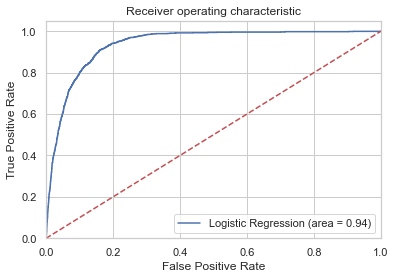

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations from the Logit Model

- It is not clear if the model is run its full iteration, due to the warning given. It apears that the ML estimation failed to converge.
- From the results, the p-value of many features has NAN result. We suspect this could be due to the large number of features which may affect the ability for the algorithm to get the coefficients for Maximum Likelihood.
- The Psedo-R-square is relatively low at 0.4
- However, the AUC performace looks promising, with a metric of 0.94.

## 6.3 Using LogisticRegression Classifier

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [43]:
from sklearn.linear_model import LogisticRegression

y_train_lr = y_train.copy()
y_train_lr = y_train_lr.squeeze()

LogisticReg = LogisticRegression(solver='liblinear')
LogisticReg.fit(X_train, y_train_lr)

LogisticRegression(solver='liblinear')

In [44]:
LogisticReg.__dict__

{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'liblinear',
 'max_iter': 100,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'n_features_in_': 63,
 'classes_': array([0, 1], dtype=int64),
 'coef_': array([[ 2.34875816e-03, -3.32384902e-01,  4.62868981e-03,
         -3.57919383e-02,  1.13398399e-03, -3.84086683e-01,
          3.34682371e-01,  1.39719465e-02, -7.16413374e-02,
         -6.56860263e-03,  4.72724627e-02, -2.14875641e-01,
         -6.78819664e-02, -3.78564020e-02, -6.35213110e-03,
          2.25647258e-01, -9.26262817e-02, -7.84750025e-02,
          1.78391551e-01, -4.34595930e-02,  4.40402859e-02,
          4.85758058e-02, -2.54585256e-02, -4.20948542e-02,
          6.83931645e-02,  1.56056103e-03, -6.11057211e-02,
          2.14871600e-03,  1.36869083e-02,  1.60574287e-02,
          5.12946408e-02, -1.968

In [45]:
print_score(LogisticReg, X_train, y_train, X_test, y_test, train=True)
print_score(LogisticReg, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 91.02%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.928308     0.667829  0.910166      0.798068      0.898819
recall         0.973912     0.410846  0.910166      0.692379      0.910166
f1-score       0.950563     0.508725  0.910166      0.729644      0.900542
support    25567.000000  3264.000000  0.910166  28831.000000  28831.000000
_______________________________________________
Confusion Matrix: 
 [[24900   667]
 [ 1923  1341]]

Test Result:
Accuracy Score: 91.18%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.929782     0.668235  0.911791      0.799009      0.900658
recall         0.974319     0.412791  0.911791      0.693555      0.911791
f1-score       0.951530     0.510332  0.911791      0.730931      0.902401
support   

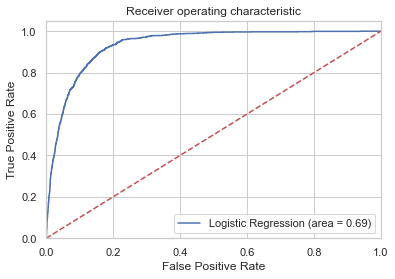

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, LogisticReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogisticReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations

- Compared to the prior 2 model which failed to converged, this model successfully converged (we did not get any warnings using this library function. The AUC is lower at 0.69 compared to the other two Probit and Logit models.
- The difference in Logistic Regression result using Scikit-Learn vs Statsmodels is likely due to Scikit-Learn models use regulariation, and that it can handle spare inputs (much like our data which has a large number of one-hot encoded features)


*Ref: https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels*

# 6a. Feature Removal Using P-Values

- We try to remove features based on the p-values of the regression. Looking at the outcome from the Probit link function, we noe that we can keep only a few of the features (at 0.05 level): ['contact', 'duration', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m'] (which are all numerical value features).

- The categorical features all seem to have high P-values

In [47]:
X = df.loc[:, df.columns != 'y']
y = df.loc[:, df.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [48]:
col_p_val = ['contact', 'duration', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m']

In [49]:
model_p = Probit(y_train, X_train[col_p_val])
probit_model = model_p.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.234017
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                         Probit   Df Residuals:                    28825
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.3374
Time:                        19:14:13   Log-Likelihood:                -6747.0
converged:                       True   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
contact           -0.2495      0.032     -7.748      0.000      -0.313      -0.186
duration         

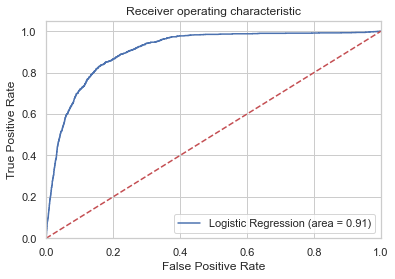

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, probit_model.predict(X_test[col_p_val]))
fpr, tpr, thresholds = roc_curve(y_test, probit_model.predict(X_test[col_p_val]))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations

The logistic regression is able to stop after 7 iterations. However, the performance of the model appears to be lower compared to the regression that uses the full set of data.

# 7. Simple Feature Selection

We try to see if we can improve the performance of the model by doing simple feature reduction

## 7.1 Categorical Feature Reduction

We examine (visually and statistically) the outputs of the categorical features to see which ones appear to have distinguishing features.

### 7.1.1 Visual Examination

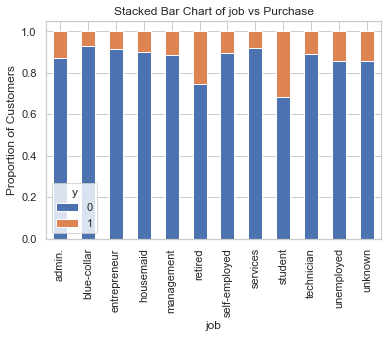

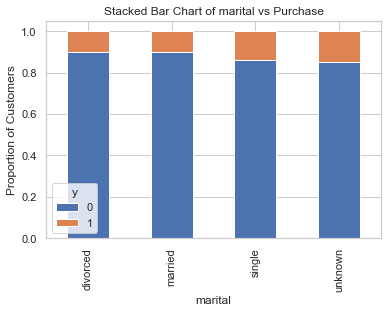

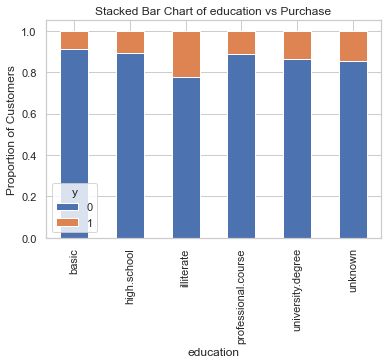

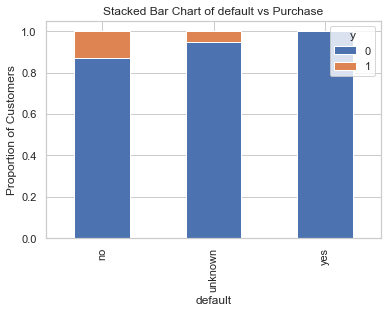

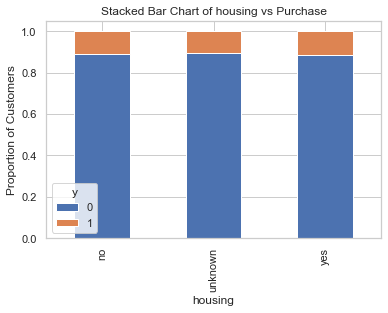

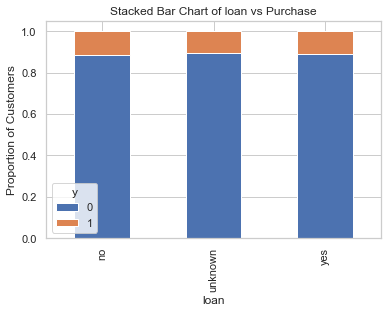

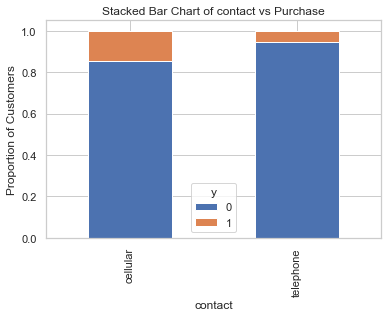

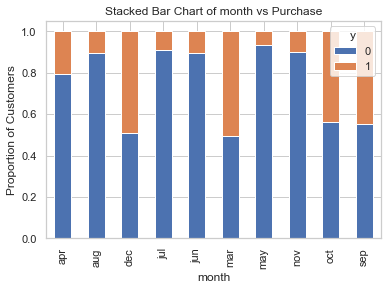

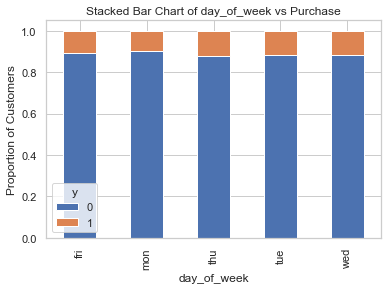

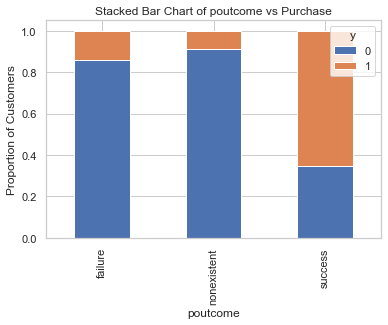

In [52]:
# we also plot a stacked bar chart to see if there are obvious distinctions on categorical features

for col in coltype_cat:
    table = pd.crosstab(data[col], data.y)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title(f'Stacked Bar Chart of {col} vs Purchase')
    plt.xlabel(col)
    plt.ylabel('Proportion of Customers')

### 7.1.2 Statistical Examinatioin

We perform chi-squared tests for categorical features, to see if there are relationships between the input categorical features and the outcome `y`.

In [53]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

prob = 0.99

cat_feat_remove = []

for col in coltype_cat:
    table = pd.crosstab(data['y'], data[col]).to_numpy()

    stat, p, dof, expected = chi2_contingency(table)
    critical = chi2.ppf(prob, dof)
    print('-' * 20)
    print(col)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        cat_feat_remove.append(col)

--------------------
job
probability=0.990, critical=24.725, stat=966.056
Dependent (reject H0)
--------------------
marital
probability=0.990, critical=11.345, stat=122.655
Dependent (reject H0)
--------------------
education
probability=0.990, critical=15.086, stat=177.361
Dependent (reject H0)
--------------------
default
probability=0.990, critical=9.210, stat=406.578
Dependent (reject H0)
--------------------
housing
probability=0.990, critical=9.210, stat=5.684
Independent (fail to reject H0)
--------------------
loan
probability=0.990, critical=9.210, stat=1.094
Independent (fail to reject H0)
--------------------
contact
probability=0.990, critical=6.635, stat=862.318
Dependent (reject H0)
--------------------
month
probability=0.990, critical=21.666, stat=3101.149
Dependent (reject H0)
--------------------
day_of_week
probability=0.990, critical=13.277, stat=26.145
Dependent (reject H0)
--------------------
poutcome
probability=0.990, critical=9.210, stat=4230.524
Dependent (r

In [54]:
cat_feat_remove

['housing', 'loan']

### Observations:

Based on the visualization, as well as the statistical tests, we remove `housing` and `loan` from the training features

In [55]:
data_new = data.copy()

In [56]:
data_new = data_new.drop(cat_feat_remove, axis=1)

## 7.2 Numerical Feature Reduction

We run a correlation analysis on numerical features

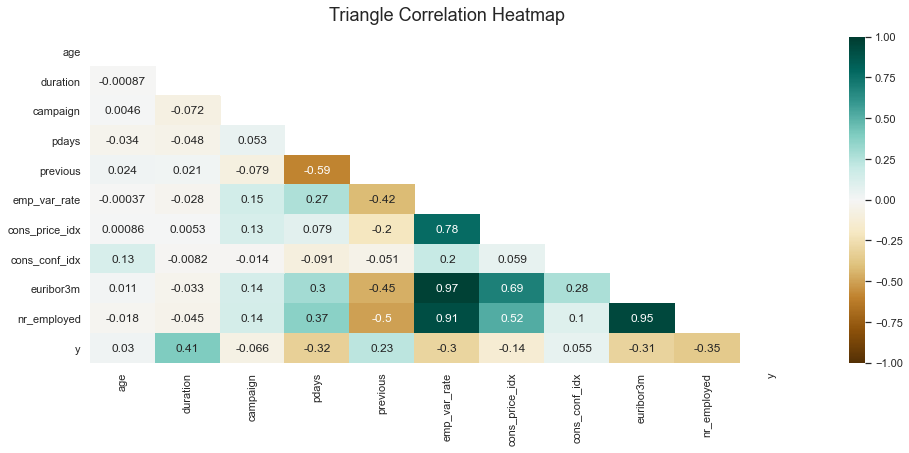

In [57]:
# We run a quick correlation analysis between the features:

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

### Observations

For target `y` and correlations amongst features, `duration` has unsurprisingly the highest correlation (however cannot be used in the model). `pdays` and `previous` has high correlations, as do `emp_var_rate`. Here we note that there is high correlation between `emp_var_rate` and some economic indicates such as `nr_emp` and `euribor3m` so we can consider dropping two of these three features.

We will drop the following columns: `duration`, `pdays`, `emp_var_rate`, `cons_price_idx`, `nr_employed` based on the correlations of the features.

In [58]:
num_feat_remove = ['duration', 'pdays', 'pdays_cat', 'emp_var_rate', 'cons_price_idx', 'nr_employed']

data_new = data_new.drop(num_feat_remove, axis=1)

In [59]:
data_new.columns

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'day_of_week', 'campaign', 'previous', 'poutcome', 'cons_conf_idx',
       'euribor3m', 'y'],
      dtype='object')

# 8 Re-running the models with reduced number of features

In [60]:
df_new = data_new.copy()

# label encode features with only 2 categories
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# track the columns that is transformed
le_track = []

# iterate through the column names in the dataset
for col in df_new:
    # if the columns are categorical:
    if df_new[col].dtype == 'object':
        
        # if the number of categories are 2, we use Label Encoding:
        if df_new[col].nunique() <= 2:
            # fit the column
            le.fit(df_new[col])
            # transform the data set
            df_new[col] = le.transform(df_new[col])
        
            le_track.append(col)
            

# one-hot encode remaining categories
df_new = pd.get_dummies(df_new)

In [61]:
df_new.columns

Index(['age', 'contact', 'campaign', 'previous', 'cons_conf_idx', 'euribor3m',
       'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'month_apr', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

## 8.1 Probit Link Function

In [64]:
from statsmodels.discrete.discrete_model import Probit
from sklearn.model_selection import train_test_split

X = df_new.loc[:, df_new.columns != 'y']
y = df_new.loc[:, df_new.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [65]:
model = Probit(y_train, X_train)
probit_model = model.fit()
print(probit_model.summary())

         Current function value: 0.282164
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                         Probit   Df Residuals:                    28788
Method:                           MLE   Df Model:                           42
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.2011
Time:                        19:17:09   Log-Likelihood:                -8135.1
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0008      0.001      0.596      0.551      -0.002       0.003
contact 

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


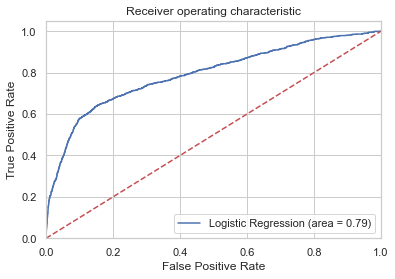

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, probit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, probit_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Logit Link Function

In [67]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y_train, X_train)
logit_model = model.fit()
print(logit_model.summary())

         Current function value: 0.281762
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28788
Method:                           MLE   Df Model:                           42
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.2022
Time:                        19:17:15   Log-Likelihood:                -8123.5
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0018      0.002      0.715      0.475      -0.003       0.007
contact 

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


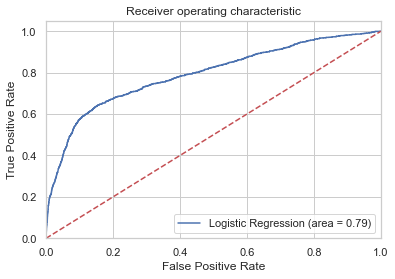

In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 8.3 Using LogisticRegression Classified

In [69]:
from sklearn.linear_model import LogisticRegression

y_train_lr = y_train.copy()
y_train_lr = y_train_lr.squeeze()

LogisticReg = LogisticRegression(solver='liblinear')
LogisticReg.fit(X_train, y_train_lr)

LogisticRegression(solver='liblinear')

In [70]:
print_score(LogisticReg, X_train, y_train, X_test, y_test, train=True)
print_score(LogisticReg, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 89.71%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.906098     0.648406  0.897125      0.777252      0.876925
recall         0.986193     0.199449  0.897125      0.592821      0.897125
f1-score       0.944451     0.305061  0.897125      0.624756      0.872064
support    25567.000000  3264.000000  0.897125  28831.000000  28831.000000
_______________________________________________
Confusion Matrix: 
 [[25214   353]
 [ 2613   651]]

Test Result:
Accuracy Score: 90.04%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.908497     0.671395   0.90038      0.789946      0.882095
recall         0.987342     0.206395   0.90038      0.596869      0.900380
f1-score       0.946280     0.315731   0.90038      0.631005      0.876066
support   

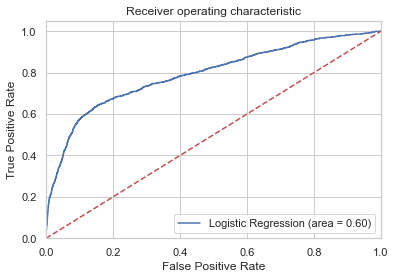

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, LogisticReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogisticReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations

After reducing the number of the features, the models all recorded poorer performance in terms of psedo-r-square and AUC score.

It seems that a somewhat arbitraty removal of features may not be the best approach. Also, metrics such as CPI, and employement-related indices should play a significant role in predicting whether people will sign up for term deposits.

For next steps, we will investigate if balancing the dataset, and using feature reduction techniques like PCA can result in better model performance.

---

# 9. Feature Scaling

We also try to scale the feature so see if we can improve the performance of the model. In theory, if the algorithms use a gradient descent method to find the optimal esimators for the models, then they may be sensitive to the magnitude of the dataset and feature scaling may help.

In [93]:
df_scale = pd.read_csv('banking.csv', header=0)

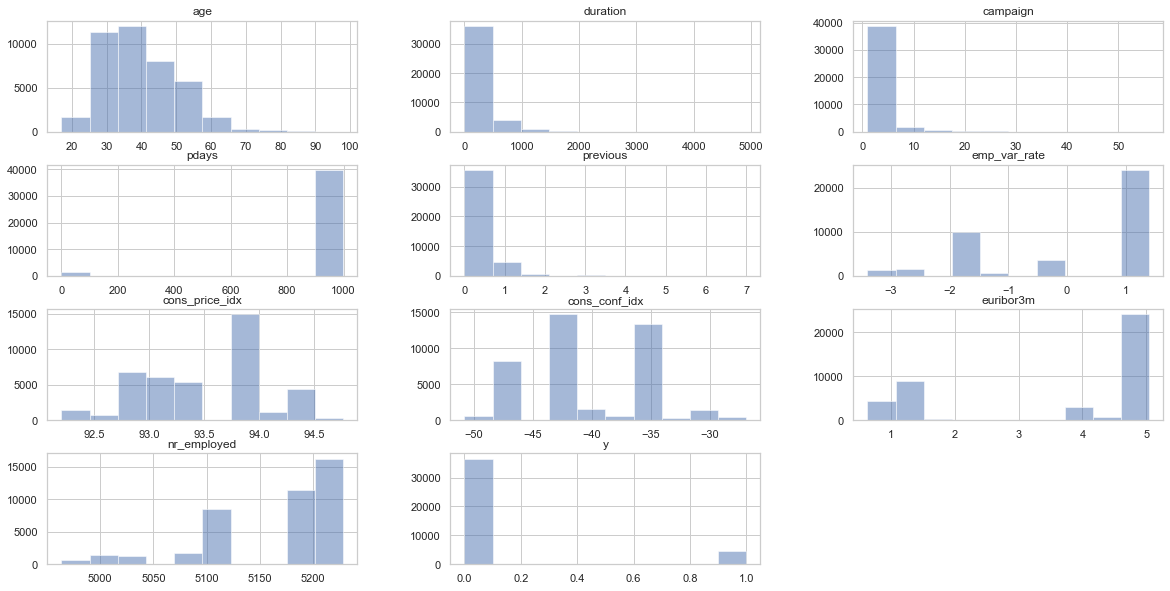

In [94]:
df_scale.hist(alpha=0.5, figsize=(20,10))
plt.show()

In [95]:
df_scale.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

### Comment:

We remove `pdays` from the dataset, as most of the data indicates that clients were not contacted prior. We also remove `duration` as per the data information (i.e. not a good predictive indicator as results from call is already known by end of the call)

In [96]:
df_scale = df_scale.drop(['pdays', 'duration'], axis=1)

X = df_scale.loc[:, df_scale.columns != 'y']
y = df_scale.loc[:, df_scale.columns == 'y']

In [97]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed'],
      dtype='object')

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [99]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
31880,31,technician,single,university.degree,no,no,no,cellular,nov,tue,1,1,failure,-0.1,93.200,-42.0,4.153,5195.8
38177,44,admin.,married,professional.course,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2459,43,management,married,professional.course,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
756,35,blue-collar,married,basic.4y,no,no,no,cellular,nov,tue,2,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
11275,33,admin.,single,university.degree,no,yes,yes,cellular,may,thu,2,1,failure,-1.8,92.893,-46.2,1.266,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,57,blue-collar,married,basic.4y,no,yes,yes,telephone,may,tue,7,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
32103,36,blue-collar,single,basic.9y,no,no,yes,telephone,may,thu,3,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
30403,31,technician,married,professional.course,no,no,no,telephone,jun,wed,2,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
21243,29,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,2,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1


### Comment

We train the scaler using only X_train, and then transform both the train __and__ test datasets using the trained scaler to avoid leakage

In [100]:
# define the columns that we want to normalize
col_to_norm = coltype_num.copy()
col_to_norm.remove('duration')
col_to_norm.remove('pdays')
col_to_norm.remove('y')

# separate data into ones we want to normalize, and other (categorical) that cannot be normalized
X_train_norm = X_train[col_to_norm].copy()
X_test_norm = X_test[col_to_norm].copy()

X_train_cat = X_train[coltype_cat].copy()
X_test_cat = X_test[coltype_cat].copy()

In [101]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

# training the scaler using training dataset only
mm.fit(X_train_norm)

X_train_norm = mm.transform(X_train_norm)
X_test_norm = mm.transform(X_test_norm)

In [102]:
X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.columns = col_to_norm
X_train_cat = X_train_cat.reset_index(drop=True)
X_train2 = pd.concat([X_train_norm, X_train_cat], axis=1)
y_train2 = y_train.reset_index(drop=True)

X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.columns = col_to_norm
X_test_cat = X_test_cat.reset_index(drop=True)
X_test2 = pd.concat([X_test_norm, X_test_cat], axis=1)
y_test2 = y_test.reset_index(drop=True)

In [103]:
X_train_cat

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,technician,single,university.degree,no,no,no,cellular,nov,tue,failure
1,admin.,married,professional.course,no,yes,no,telephone,may,mon,nonexistent
2,management,married,professional.course,no,yes,no,telephone,may,mon,nonexistent
3,blue-collar,married,basic.4y,no,no,no,cellular,nov,tue,nonexistent
4,admin.,single,university.degree,no,yes,yes,cellular,may,thu,failure
...,...,...,...,...,...,...,...,...,...,...
28826,blue-collar,married,basic.4y,no,yes,yes,telephone,may,tue,nonexistent
28827,blue-collar,single,basic.9y,no,no,yes,telephone,may,thu,nonexistent
28828,technician,married,professional.course,no,no,no,telephone,jun,wed,nonexistent
28829,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,nonexistent


In [116]:
def label_encoding(df):
    
    # label encode features with only 2 categories
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()

    # track the columns that is transformed
    le_track = []

    # iterate through the column names in the dataset
    for col in df:
        # if the columns are categorical:
        if df[col].dtype == 'object':
        
            # if the number of categories are 2, we use Label Encoding:
            if df[col].nunique() <= 2:
                # fit the column
                le.fit(df[col])
                # transform the data set
                df[col] = le.transform(df[col])

    # one-hot encode remaining categories
    df = pd.get_dummies(df)
    
    return df

In [105]:
# encode the categorical data

X_train2 = label_encoding(X_train2)
X_test2 = label_encoding(X_test2)

## 9.2 Run Probit Link Model with Normalized Features

In [106]:
model = Probit(y_train2, X_train2)
probit_model = model.fit()
print(probit_model.summary())

         Current function value: 0.278047
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                         Probit   Df Residuals:                    28780
Method:                           MLE   Df Model:                           50
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.2127
Time:                        19:28:47   Log-Likelihood:                -8016.4
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0053      0.108      0.050      0.960      -0.206       0.216
campaign

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


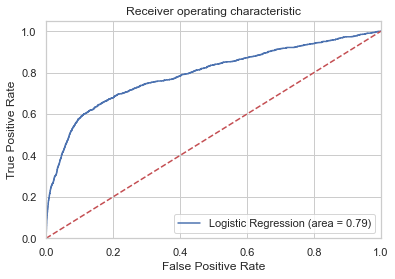

In [107]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, probit_model.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, probit_model.predict(X_test2))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations from the Probit Model

- After normalization, we still have not achieved convergence, which is not surprising given the large number of features.

## 9.3 Run Logit Link Model with Normalized Features

In [108]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y_train2, X_train2)
logit_model = model.fit()
print(logit_model.summary())

         Current function value: 0.277951
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28780
Method:                           MLE   Df Model:                           50
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.2130
Time:                        19:29:31   Log-Likelihood:                -8013.6
converged:                      False   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0074      0.205      0.036      0.971      -0.394       0.409
campaign

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


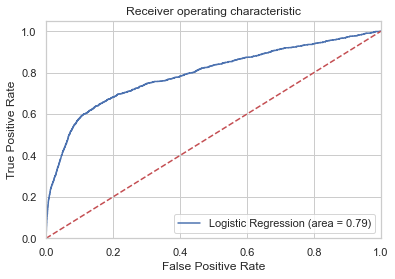

In [109]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logit_model.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, logit_model.predict(X_test2))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations from the Logit Model

- After normalization, we still have not achieved convergence, which is not surprising given the large number of features.

## 9.4 Using LogisticRegression Classifier after Normalization of Features

In [110]:
from sklearn.linear_model import LogisticRegression

y_train_lr = y_train2.copy()
y_train_lr = y_train_lr.squeeze()

LogisticReg = LogisticRegression(solver='liblinear')
LogisticReg.fit(X_train2, y_train_lr)

LogisticRegression(solver='liblinear')

In [111]:
print_score(LogisticReg, X_train2, y_train2, X_test2, y_test2, train=True)
print_score(LogisticReg, X_train2, y_train2, X_test2, y_test2, train=False)

Train Result:
Accuracy Score: 89.86%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.907762     0.659475  0.898581      0.783618      0.879653
recall         0.985802     0.215380  0.898581      0.600591      0.898581
f1-score       0.945174     0.324711  0.898581      0.634942      0.874930
support    25567.000000  3264.000000  0.898581  28831.000000  28831.000000
_______________________________________________
Confusion Matrix: 
 [[25204   363]
 [ 2561   703]]

Test Result:
Accuracy Score: 90.29%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.910587     0.697309  0.902889      0.803948      0.886838
recall         0.987706     0.226017  0.902889      0.606862      0.902889
f1-score       0.947580     0.341383  0.902889      0.644482      0.880078
support   

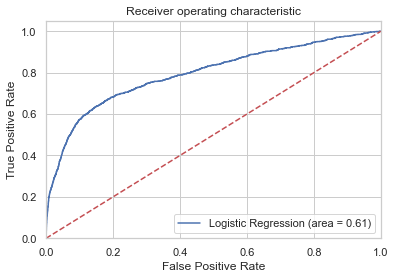

In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, LogisticReg.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, LogisticReg.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations:

We did not notice any changes in the performances of the Logistic regression from normalizing the features.

---

# 10. Over-sampling Training Data using SMOTE

As the data is imbalanced, We will try to up-sample our training data, to see if that improves the performance of the model.

In [117]:
df_bal = pd.read_csv('banking.csv', header=0)

X = df_bal.loc[:, df_bal.columns != 'y']
y = df_bal.loc[:, df_bal.columns == 'y']

X = label_encoding(X)

C:\Users\aooi5\AppData\Local\Temp\ipykernel_17492\3142629839.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.transform(df[col])


In [118]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## 10.1 Running the Probit Link Model with Balanced Data Training

In [119]:
model = Probit(os_data_y, os_data_X)
probit_model = model.fit()
print(probit_model.summary())

         Current function value: 0.119156
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                51134
Model:                         Probit   Df Residuals:                    51073
Method:                           MLE   Df Model:                           60
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  0.8281
Time:                        19:35:24   Log-Likelihood:                -6092.9
converged:                      False   LL-Null:                       -35443.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0003      0.002      0.175      0.861      -0.003       0.003
contact 

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


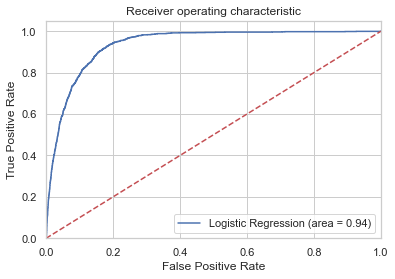

In [120]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, probit_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, probit_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observation

It appears that after over-sampling, the Psedo-R-Square for the Probit model has increased (from 0.4 to 0.8). The AUC remained the same. However, we cannot fully rely on these results as there is no convergence.

## 10.2 Using the Logit Link Function

In [121]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(os_data_y, os_data_X)
logit_model = model.fit()
print(logit_model.summary())

C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\aooi5\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

### Observation

Running the logit link function raises a singular matrix error.

## 10.4 Using LogisticRegression Classifier with Balanced Features Training

In [122]:
from sklearn.linear_model import LogisticRegression

y_train_lr = os_data_y.copy()
y_train_lr = y_train_lr.squeeze()

LogisticReg = LogisticRegression(solver='liblinear')
LogisticReg.fit(os_data_X, y_train_lr)

LogisticRegression(solver='liblinear')

In [123]:
print_score(LogisticReg, os_data_X, os_data_y, X_test, y_test, train=True)
print_score(LogisticReg, os_data_X, os_data_y, X_test, y_test, train=False)

Train Result:
Accuracy Score: 94.84%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.929529      0.969070   0.94843      0.949300      0.949300
recall         0.970431      0.926429   0.94843      0.948430      0.948430
f1-score       0.949540      0.947269   0.94843      0.948405      0.948405
support    25567.000000  25567.000000   0.94843  51134.000000  51134.000000
_______________________________________________
Confusion Matrix: 
 [[24811   756]
 [ 1881 23686]]

Test Result:
Accuracy Score: 91.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.932116     0.657519  0.911872      0.794818      0.901539
recall         0.971587     0.435320  0.911872      0.703454      0.911872
f1-score       0.951442     0.523830  0.911872      0.737636      0.903826
suppo

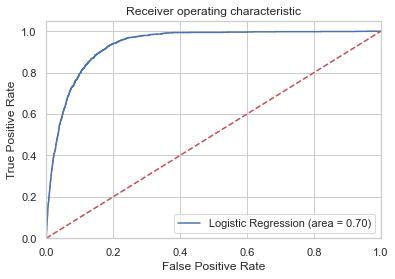

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, LogisticReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogisticReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observation

We note that there is no significant improvement in the model performance after balancing the data.

---

# Section 11 - Dimensionality Reduction using Principal Component Analysis

## 11.1 - Standardizing Data

Here we standardize the numerical dataset __only__ (i.e. the categorical data is labelled using one-hot encoding, but we __do not__ standardize these data).


We split the data into training and test dataset, and train the Standard Scaler using only the training dataset. Test data is then standardized using the trained Standard Scaler.

In [125]:
df = pd.read_csv('banking.csv', header=0)

In [126]:
X = df.loc[:, df.columns != 'y']
y = df.loc[:, df.columns == 'y']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [128]:
# define features with numerical and categorical data
coltype_num = list(data.select_dtypes(include=['int64', 'float64']).columns)
coltype_cat = list(data.select_dtypes(include=['object']).columns)

# remove target variable from data feeatures
col_to_std = coltype_num[:-1]

In [129]:
# separate data into ones we want to normalize, and other (categorical) that cannot be normalized
X_train_std = X_train[col_to_std].copy()
X_test_std = X_test[col_to_std].copy()

X_train_cat = X_train[coltype_cat].copy()
X_test_cat = X_test[coltype_cat].copy()

In [130]:
# Scale the numerical features

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train_std)

X_train_std = ss.transform(X_train_std)
X_test_std = ss.transform(X_test_std)

In [131]:
X_train_std = pd.DataFrame(X_train_std)
X_train_std.columns = col_to_std
X_train_cat = X_train_cat.reset_index(drop=True)
X_train_pca = pd.concat([X_train_std, X_train_cat], axis=1)
y_train_pca = y_train.reset_index(drop=True)

X_test_std = pd.DataFrame(X_test_std)
X_test_std.columns = col_to_std
X_test_cat = X_test_cat.reset_index(drop=True)
X_test_pca = pd.concat([X_test_std, X_test_cat], axis=1)
y_test_pca = y_test.reset_index(drop=True)

In [132]:
# encode the categorical data

X_train_pca = label_encoding(X_train_pca)
X_test_pca = label_encoding(X_test_pca)

In [133]:
X_train_pca.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,contact,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.00000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000
mean,1.476280e-16,-9.676280e-17,-1.523490e-16,-1.278520e-15,-9.980185e-16,-8.900730e-17,-1.984493e-14,-1.088501e-15,3.211949e-17,3.895130e-15,0.363879,0.251882,0.228018,0.034685,0.024869,0.071694,0.042003,0.034893,0.096563,0.020638,0.161528,0.025077,0.008151,0.110194,0.609032,0.278797,0.001977,0.102112,0.056432,0.149076,0.228088,0.000520,0.127987,0.293434,0.04235,0.789636,0.210329,0.000035,0.451424,0.023967,0.524609,0.823801,0.023967,0.152232,0.063369,0.149422,0.004821,0.171864,0.130276,0.013319,0.334744,0.101072,0.017412,0.013701,0.190663,0.205092,0.211821,0.194513,0.197912,0.104818,0.861919,0.033263
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.481123,0.434101,0.419562,0.182984,0.155729,0.257984,0.200600,0.183512,0.295367,0.142170,0.368023,0.156362,0.089915,0.313137,0.487976,0.448415,0.044421,0.302801,0.230759,0.356169,0.419607,0.022804,0.334081,0.455344,0.20139,0.407574,0.407549,0.005889,0.497643,0.152950,0.499403,0.380996,0.152950,0.359252,0.243630,0.356511,0.069268,0.377268,0.336613,0.114639,0.471909,0.301429,0.130802,0.116247,0.392831,0.403776,0.408605,0.395832,0.398432,0.306324,0.344990,0.179325
min,-2.212081e+00,-9.893149e-01,-5.685632e-01,-5.160750e+00,-3.526629e-01,-2.205329e+00,-2.362116e+00,-2.219380e+00,-1.713825e+00,-2.810328e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.728813e-01,-5.979239e-01,-5.685632e-01,1.949852e-01,-3.526629e-01,-1.188796e+00,-8.563535e-01,-4.709471e-01,-1.305037e+00,-9.357338e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

---

## 11.2 - Run Principal Component Analysis

In [134]:
def pca_fn(X_train_pca, X_test_pca, n, calc_pca=True):

    from sklearn.decomposition import PCA

    pca_dims = n
    pca_cols = ['pca'+str(i) for i in range(1, pca_dims+1)]

    pca = PCA(n_components = pca_dims)
    pca.fit(X_train_pca)
    
    if calc_pca:
        X_train_reducedD = pca.transform(X_train_pca)
        X_train_reducedD = pd.DataFrame(data = X_train_reducedD, columns = pca_cols)

        X_test_reducedD = pca.transform(X_test_pca)
        X_test_reducedD = pd.DataFrame(data = X_test_reducedD, columns = pca_cols)
    
        return X_train_reducedD, X_test_reducedD, pca.explained_variance_ratio_
    
    else:
        return pca.explained_variance_ratio_

We run a quick test to see how many principal components we'd like to keep. The original dataset has a total of __62__ features

In [135]:
X_train_pca.shape

(28831, 62)

<Figure size 432x288 with 0 Axes>

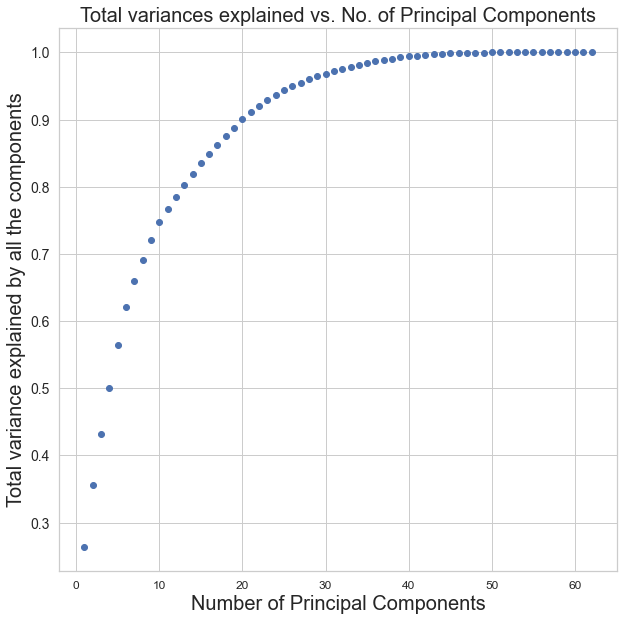

In [136]:
explained = pca_fn(X_train_pca, X_test_pca, 62, calc_pca=False)
explained_marginal = np.cumsum(explained)

index = [i for i in range(1, 63)]

import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Number of Principal Components',fontsize=20)
plt.ylabel('Total variance explained by all the components', fontsize=20)
plt.title("Total variances explained vs. No. of Principal Components",fontsize=20)

plt.scatter(index, explained_marginal)

### Observation:

It appears that, with 15 principal components, we can explain more than 80% of the variation. Hence, we will use this number for feature reduction.

In [137]:
# we use PCA to reduce our dataset from 62 features to 15 features

X_train_reducedD, X_test_reducedD, explained = pca_fn(X_train_pca, X_test_pca, 15, calc_pca=True)

In [138]:
X_train_reducedD

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,0.758725,0.157460,1.164816,0.435390,-0.704195,-0.461391,-1.187026,1.847899,0.442919,-0.581506,0.357249,-0.136771,-0.322038,-0.434981,-0.477207
1,-1.286850,0.606348,-0.634266,0.571025,-0.333152,-0.170693,0.464871,-0.610198,0.624532,-0.231161,-0.568060,-0.150066,-0.090957,0.394962,-0.247235
2,-1.306461,0.551013,-0.645857,0.113195,-0.593511,-0.515904,0.559282,-0.610229,0.639234,0.041201,-0.547127,-0.434510,-0.126089,0.004273,-0.324825
3,-0.161838,-0.709255,-0.098156,-0.033347,-0.265680,-0.332251,-0.392387,0.700471,-0.643911,0.918538,-0.370498,-0.325845,-0.177800,-0.149340,-0.197614
4,2.990041,-0.795823,1.159302,-0.089872,-0.004924,-0.215463,-0.694588,0.348665,1.204118,-0.849480,0.251048,0.990300,0.877373,-0.042126,-0.682215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,-1.507487,1.063341,-1.141970,-0.047689,1.635918,1.679598,0.477228,-0.567324,0.822010,0.232400,-0.161647,-0.094665,1.135121,-0.161916,-0.914682
28827,-1.355958,0.305367,0.375298,0.824785,-0.282065,0.777596,1.022880,0.405324,-0.050058,0.173489,0.556161,-0.081974,1.167819,-0.612749,-0.953126
28828,-1.966551,0.140599,1.073913,0.698806,0.197040,-0.313433,0.724054,0.409764,-0.371163,-0.055975,-0.795909,-0.631198,-0.213179,-0.672097,0.173914
28829,2.044856,-1.864997,0.383028,-0.058904,0.031218,-0.193591,0.677468,0.422581,-0.633440,1.240011,-0.502556,-0.096282,-0.142205,-0.045810,-0.578938


---

## 11.3 - Run Logistic Regression Models

Next we run our regression models to see if they result in better model performance

## 11.3.1 Probit Link Model

In [139]:
model = Probit(y_train_pca, X_train_reducedD)
probit_model = model.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.619527
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                         Probit   Df Residuals:                    28816
Method:                           MLE   Df Model:                           14
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                 -0.7542
Time:                        19:39:17   Log-Likelihood:                -17862.
converged:                       True   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pca1           0.1481      0.004     37.560      0.000       0.140       0.156
pca2           0.1717      0.

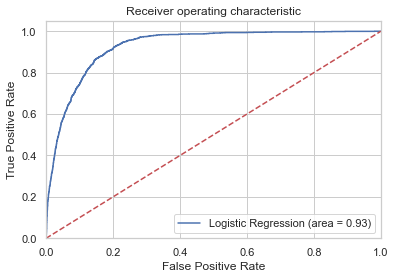

In [140]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_pca, probit_model.predict(X_test_reducedD))
fpr, tpr, thresholds = roc_curve(y_test_pca, probit_model.predict(X_test_reducedD))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations for Probit link model:

The model terminated successfully without any warning. The Pseudo-R-Square has increased in absolute value (to -0.7 from 0.4). P-values indicate that the coefficients are mostly statistically significant, except for pca12. The AUC still remained quite high at 0.93.

## 11.3.2 Logit Link Model

In [141]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y_train_pca, X_train_reducedD)
logit_model = model.fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.609095
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28816
Method:                           MLE   Df Model:                           14
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                 -0.7246
Time:                        19:39:39   Log-Likelihood:                -17561.
converged:                       True   LL-Null:                       -10182.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pca1           0.3472      0.011     30.234      0.000       0.325       0.370
pca2           0.5598      0.

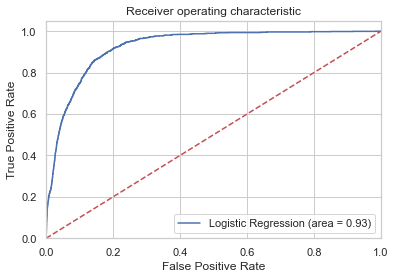

In [142]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_pca, logit_model.predict(X_test_reducedD))
fpr, tpr, thresholds = roc_curve(y_test_pca, logit_model.predict(X_test_reducedD))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations for Logit link model:

Generally, the results are similar to that of the Probit model. The model terminated successfully without any warning. The Pseudo-R-Square has increased in absolute value (to -0.7 from 0.4). P-values indicate that the coefficients are mostly statistically significant, although several are quite high. The AUC still remained quite high at 0.93.

## 11.3.3 Using LogisticRegression Classified

In [143]:
from sklearn.linear_model import LogisticRegression

y_train_lr = y_train_pca.copy()
y_train_lr = y_train_lr.squeeze()

LogisticReg = LogisticRegression(solver='liblinear')
LogisticReg.fit(X_train_reducedD, y_train_lr)

LogisticRegression(solver='liblinear')

In [144]:
print_score(LogisticReg, X_train_reducedD, y_train_pca, X_test_reducedD, y_test_pca, train=True)
print_score(LogisticReg, X_train_reducedD, y_train_pca, X_test_reducedD, y_test_pca, train=False)

Train Result:
Accuracy Score: 90.88%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.927313     0.659799  0.908848      0.793556      0.897027
recall         0.973521     0.402267  0.908848      0.687894      0.908848
f1-score       0.949855     0.499810  0.908848      0.724832      0.898905
support    25567.000000  3264.000000  0.908848  28831.000000  28831.000000
_______________________________________________
Confusion Matrix: 
 [[24890   677]
 [ 1951  1313]]

Test Result:
Accuracy Score: 91.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.929788     0.669022  0.911872      0.799405      0.900751
recall         0.974410     0.412791  0.911872      0.693601      0.911872
f1-score       0.951576     0.510562  0.911872      0.731069      0.902468
support   

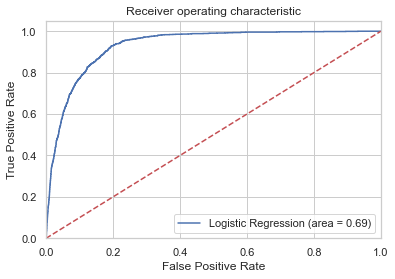

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_pca, LogisticReg.predict(X_test_reducedD))
fpr, tpr, thresholds = roc_curve(y_test_pca, LogisticReg.predict_proba(X_test_reducedD)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations:

The model's perfomance did not seem affected by the reduction in dimensionality. The classification report did not vary much from when the model used the full number of features.

# 12 Conclusion

- We achived a high-performing Logistic Regression model (ROC-AUC 0.93 using Statsmodels library) after:
    - Balancing the dataset using SMOTE
    - Standardizing the data and then drastically reducing the number of features using PCA